In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm 
import numpy as np
from sklearn import metrics

In [34]:
df = pd.read_csv("combined_index.csv")

In [35]:
df['date'] = pd.to_datetime(df['date'])
df=df.iloc[::-1]

In [36]:
temp2=df[["date","death","deathIncrease","inIcuCurrently","hospitalizedIncrease","onVentilatorCurrently","positive","death_rate","scare_index"]]

In [37]:
temp2=temp2.fillna(0)

In [38]:
temp2["r_death"] = temp2.death.pct_change(1)*100
temp2["r_deathIncrease"] = temp2.deathIncrease.pct_change(1)*100
temp2["r_inIcuCurrently"] = temp2.inIcuCurrently.pct_change(1)*100
temp2["r_hospitalizedIncrease"] = temp2.hospitalizedIncrease.pct_change(1)*100
temp2["r_onVentilatorCurrently"] = temp2.onVentilatorCurrently.pct_change(1)*100
temp2["r_positive"] = temp2.positive.pct_change(1)*100
temp2["r_death_rate"] = temp2.death_rate.pct_change(1)*100
temp2["r_scare_index"] = temp2.scare_index.pct_change(1)*100

In [39]:
temp2=temp2.fillna(0)

In [40]:
temp2.drop(385,axis=0,inplace=True) 

In [41]:
temp2.set_index("date",drop=True,inplace=True)

In [42]:
temp3= temp2.copy()
t=temp3[ ~ temp3[["r_death","r_deathIncrease","r_inIcuCurrently","r_hospitalizedIncrease","r_onVentilatorCurrently","r_positive","r_death_rate","r_scare_index"]].isin([float("inf"),float("-inf")])]
t.fillna(0,inplace=True)

In [43]:
size = int(len(t)*0.8)
train,test = t.iloc[:size],t.iloc[size:]
start_date = "2020-12-21"
end_date = "2021-03-07"

# auto-arima with multivariate

predict deathIncrease every day

this model has the formula as following:
where y is r_deathIncrease, x is r_inIcuCurrently,z is r_hospitalizedIncrease,w is r_onVentilatorCurrently and e is error

$$Y_t =\beta_{0} + \sum_{i=1}^I ( \beta_{4i} y_{t-i} + \beta_{4i-1} x_{t-i}+\beta_{4i-2} z_{t-i}+\beta_{4i-3} w_{t-i})+ \epsilon_t$$

In [44]:
from pmdarima.arima import auto_arima

In [45]:
model_auto1 = auto_arima(train.r_deathIncrease[0:], exogenous=train[["r_inIcuCurrently","r_hospitalizedIncrease","r_onVentilatorCurrently"]][0:],
                         m=5,max_order=None,max_p=7,max_q=7,
                        max_d=2, max_P=4, max_Q=4, max_D=2, 
                         maxiter=50, alpha = 0.05, n_jobs = -1,
                        trend = 'ct', information_criteria = "oob",
                        out_of_sample_size = int(len(t)*0.2))

/Users/huaxinjin/opt/anaconda3/lib/python3.8/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/huaxinjin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/huaxinjin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/huaxinjin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given w

/Users/huaxinjin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/huaxinjin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/huaxinjin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/huaxinjin/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given wit

In [46]:
model_auto1

ARIMA(order=(1, 0, 2), out_of_sample_size=77, scoring_args={},
      seasonal_order=(4, 0, 3, 5), suppress_warnings=True, trend='ct',
      with_intercept=False)

Text(0.5, 1.0, 'Predictions for deathIncrease (Complex Auto Arima)')

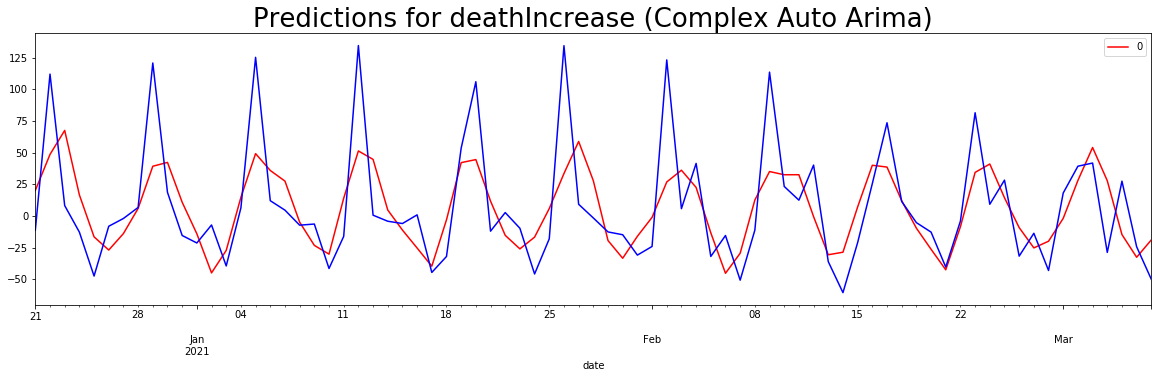

In [47]:
predict_auto1 =pd.DataFrame(model_auto1.predict(n_periods=len(test[start_date:end_date]),exogenous=test[["r_inIcuCurrently","r_hospitalizedIncrease","r_onVentilatorCurrently"]]
                                    [start_date:end_date]), index = test[start_date:end_date].index)

predict_auto1.plot(figsize=(20,5), color = "Red")

test.r_deathIncrease[start_date:end_date].plot(figsize= (20,5),color = "blue")

plt.title("Predictions for deathIncrease (Complex Auto Arima)" , size=26)

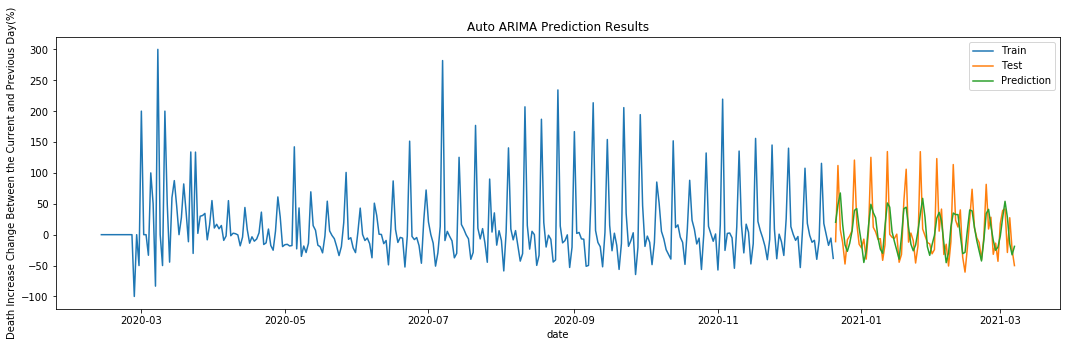

In [48]:
plt.figure(figsize = (18,5))
plt.plot(train.r_deathIncrease[0:],label = "Train")
plt.plot(test.r_deathIncrease[0:],label="Test")
plt.plot(predict_auto1,label = "Prediction")
plt.title("Auto ARIMA Prediction Results")
plt.xlabel("date")
plt.ylabel("Death Increase Change Between the Current and Previous Day(%)")
plt.legend()

In [49]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
rms = sqrt(mean_squared_error(pd.DataFrame(test.r_deathIncrease[0:]),predict_auto1))
r2 = r2_score(pd.DataFrame(test.r_deathIncrease[0:]),predict_auto1)
#mape = np.mean(np.abs(predict_auto1 - test.r_deathIncrease[0:])/np.abs(test.r_deathIncrease[0:])) 
print("RMSE = "  ,rms)
print("R^2 = ",r2)


RMSE =  35.35263854668098
R^2 =  0.4412985579470947


In [50]:
predict_auto1

,0
date,
2020-12-21,20.123477
2020-12-22,48.553671
2020-12-23,67.497987
2020-12-24,16.594268
2020-12-25,-16.548247
...,...
2021-03-03,54.011484
2021-03-04,27.788304
2021-03-05,-14.761697


In [51]:
pd.DataFrame(test.r_deathIncrease[0:])

,r_deathIncrease
date,
2020-12-21,-11.270983
2020-12-22,111.959459
2020-12-23,8.160663
2020-12-24,-12.820513
2020-12-25,-47.498310
...,...
2021-03-03,41.724537
2021-03-04,-28.828093
2021-03-05,27.423982


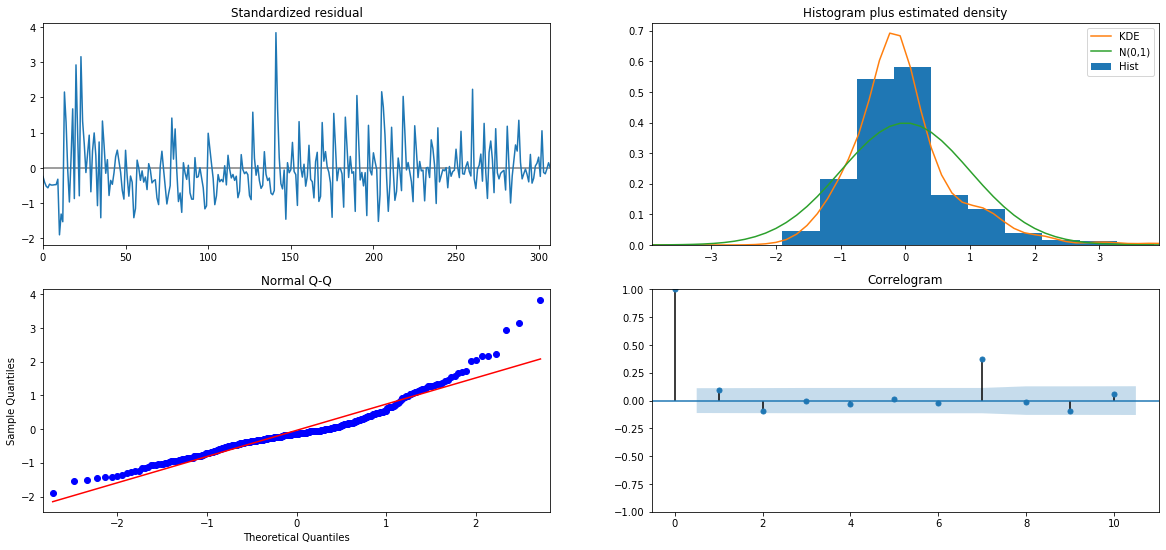

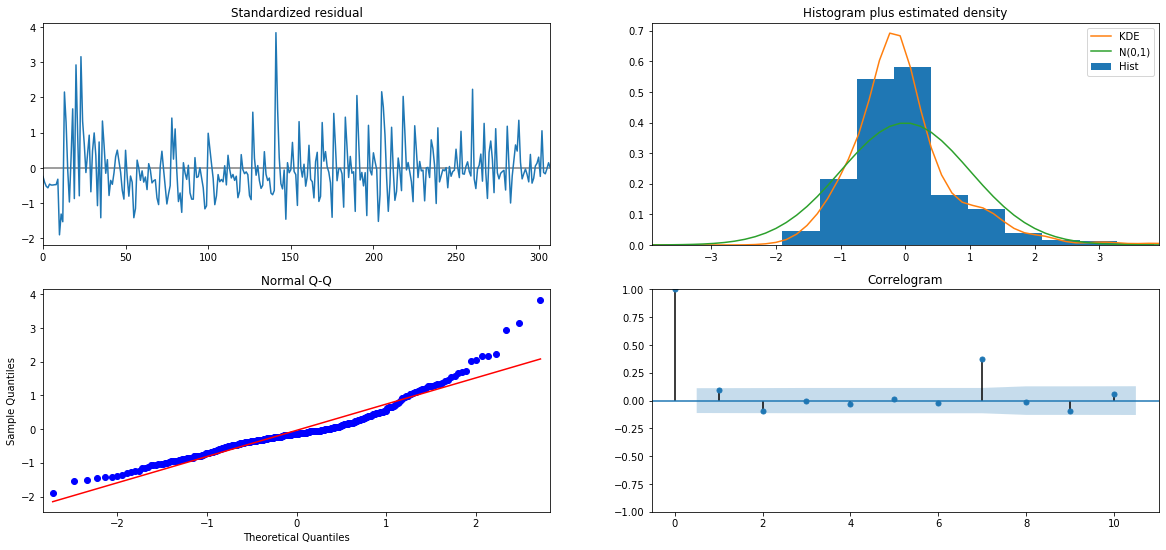

In [52]:
model_auto1.plot_diagnostics(figsize=(20,9))